In [1]:
# Import dependencies
import numpy as np
import pandas as pd

In [2]:
from IPython.display import clear_output

# Inputs:
bas_tot = 1000 # Total number of samples for baseline calculation
fl_total = 24 # Total number of files

# Pulse processing for each event
# For this test, channels 1 and 3 will be used because the pulses are unipolar
evt_smp = 100000 # Number of samples in an event
evt_acc = 0 # accumulated number of events

# Initialize energy arrays
evt_total_est = 100 # Total number of events estimative per file (only for specify the length of array)
ene_y1 = np.zeros(evt_total_est*fl_total) # Energy for each event in channel 1
ene_y3 = np.zeros(evt_total_est*fl_total) # Energy for each event in channel 3

# Process each csv file
for chnk in range(fl_total):
    fth_file = "../results/test_" + str(chnk) + ".csv" # csv file name
    df = pd.read_csv(fth_file) # Data frame from file
    content = df.values # Data frame to Numpy array

    # Each column in Numpy array from Pandas data frame     
    x0 = np.array(content[:,0]) # Horizontal scale -> T = 0.001E-08 (-5.000E-08 - -4.999E-08) 
    #y0 = np.array(content[:,1]) # Vertical - Signal 0
    y1 = np.array(content[:,2]) # Vertical - Signal 1
    #y2 = np.array(content[:,3]) # Vertical - Signal 2
    y3 = np.array(content[:,4]) # Vertical - Signal 3

    evt_tot = int(len(df.index)/evt_smp) # Total number of events    

    clear_output(wait=False)
    print("File name: {} - Processing {} event...".format(fth_file, evt_tot))
    print("Total number of events processed:",evt_acc)
    
    # Process events
    for evt_nb in range(evt_tot):        
        print("File name: {} - Processing {}/{} event...".format(fth_file, evt_nb+1, evt_tot))           
        # List of events with problems
        # Avoid these events
        blc_lst = []
        if chnk==7:
            blc_lst = [1, 45, 46, 47] # chnk = 7
        if chnk==17:
            blc_lst = [41] # chnk = 17 (see error after this event. It is necessary remove row=4200000)
        if chnk==18:
            blc_lst = [52, 53] # chnk = 18
        if chnk==19:
            blc_lst = [98] # chnk = 19 (pulse with pile-up?)
        if evt_nb in blc_lst:
            print("File name: {} - Skipping {}/{} events...".format(fth_file, evt_nb+1, evt_tot))
            continue
        
        evt_sta = evt_nb * evt_smp # Event start
        evt_end = evt_sta + evt_smp - 1 # Event end
        evt_rng = range(evt_sta, evt_end) # Event range

        # Baseline calculation - Average Moving Method
        # In the Average Moving Method, the average is calculated from the beginning 
        # of the event to the sample referring to the trigger.
        # But for simplification, the average will be calculated up to bas_tot sample 
        
        bas_y1 = np.mean(y1[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 1
        bas_y3 = np.mean(y3[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 3    
        
        # Threshold calculation 
        # For simplification the threshold will be estimed in 6 sigmas aprox.
        thr_y1 = bas_y1 + 6 * np.std(y1[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 1
        thr_y3 = bas_y3 + 6 * np.std(y3[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 3

        # Trigger
        trg_s1 = next(y for y in evt_rng if y1[y] > thr_y1) # Trigger sample for channel 1
        trg_s3 = next(y for y in evt_rng if y3[y] > thr_y3) # Trigger sample for channel 3
        trg_y1 = y1[trg_s1] # Trigger value for channel 1
        trg_y3 = y3[trg_s3] # Trigger value for channel 3
        trg_x1 = x0[trg_s1] # Trigger time for channel 1
        trg_x3 = x0[trg_s3] # Trigger time for channel 3

        # Energy calculation
        ene_y1[evt_acc] = sum(y for y in y1[trg_s1:evt_end] if y > thr_y1) # Energy of event for channel 1
        ene_y3[evt_acc] = sum(y for y in y3[trg_s3:evt_end] if y > thr_y3) # Energy of event for channel 3  

        # # Select ONLY ONE event to view threshold in leading edge of pulse    
        # smp_le_end = 10000 # Select the number of samples in leading edge for preview    
        # smp_le_sta = 5000 # Select the number of samples in leading edge for preview    
        # evt_sta = evt_nb * evt_smp + smp_le_sta# Event start
        # evt_end = evt_sta + smp_le_end - 1 # Event end
        # evt_rng = range(evt_sta, evt_end) # Event range

        evt_acc = evt_acc + 1
print("Total number of events:",evt_acc)

File name: ../results/test_23.csv - Processing 99 event...
Total number of events processed: 2286
File name: ../results/test_23.csv - Processing 1/99 event...
File name: ../results/test_23.csv - Processing 2/99 event...
File name: ../results/test_23.csv - Processing 3/99 event...
File name: ../results/test_23.csv - Processing 4/99 event...
File name: ../results/test_23.csv - Processing 5/99 event...
File name: ../results/test_23.csv - Processing 6/99 event...
File name: ../results/test_23.csv - Processing 7/99 event...
File name: ../results/test_23.csv - Processing 8/99 event...
File name: ../results/test_23.csv - Processing 9/99 event...
File name: ../results/test_23.csv - Processing 10/99 event...
File name: ../results/test_23.csv - Processing 11/99 event...
File name: ../results/test_23.csv - Processing 12/99 event...
File name: ../results/test_23.csv - Processing 13/99 event...
File name: ../results/test_23.csv - Processing 14/99 event...
File name: ../results/test_23.csv - Process

In [3]:
# Save energy data
import datetime
now = datetime.datetime.now()

dataset =pd.DataFrame({'ene_y1': ene_y1, 'ene_y3': ene_y3})
ene_file = "../results/energy_" + str(now.strftime("%Y-%m-%d_%H-%M-%S")) + ".csv"
dataset.to_csv(ene_file)

In [2]:
# This step is not necessary if energy data has already been loaded.
# Read energy data
ene_file = "../results/energy.csv"
df = pd.read_csv(ene_file) # Data frame from file
content = df.values
ene_y1 = np.array(content[:,1])
ene_y3 = np.array(content[:,2])

Channel 1: Peak index: 99, Non-calibrated x: 23476.23760402921, y: 213
Channel 3: Peak index: 83, Non-calibrated x: 22753.80491157298, y: 207


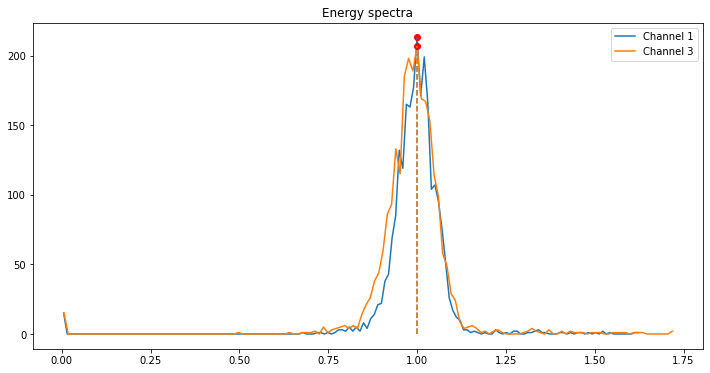

In [4]:
# Data analysis from pulses energy data
# 1-) Peak finder from energy spectra. This peak in x-axix will be the 511 keV
# 2-) Calibrate spectrum to 511 keV energy
# 3-) Isolate the 511 keV peak distribution from spectrum and calculates the baseline
# 4-) There are a lot of methods to do a fit for baseline. Choose one
# 5-) Remove the baseline from 511 keV peak distribution and calculates the Gaussian
# 6-) Calculate FWHM and the energy resolution

import matplotlib.pyplot as plt
%matplotlib inline

## Check scipy
try:
  import scipy
except:
  %pip install scipy
  import scipy

## Peak find from energy spectrum
from scipy.signal import find_peaks
plt.figure(figsize = (12, 6))
plt.title('Energy spectra')

# Channel 1:
y0, binedges0 = np.histogram(ene_y1, bins = "auto")
x0 = 0.5*(binedges0[1:] + binedges0[:-1])
peaks0, _ = find_peaks(y0, prominence = 100)
peak0 = np.amax(peaks0) # Find peak 
print("Channel 1: Peak index: {}, Non-calibrated x: {}, y: {}".\
      format(peak0, x0[peak0], y0[peak0])) # Verify if there is only one peak found
# divisor0 = x0[peak0]/511 # Calibrate in energy here
divisor0 = x0[peak0]
nx0 = np.true_divide(x0, divisor0)
plt.plot(nx0, y0, label='Channel 1')
plt.plot(nx0[peak0], y0[peak0], 'ro')
plt.vlines(x = nx0[peak0], ymin = 0, ymax = y0[peak0], linestyles = "dashed", color = "C0")

# Channel 3:
y1, binedges1 = np.histogram(ene_y3, bins = "auto")
x1 = 0.5*(binedges1[1:] + binedges1[:-1])
peaks1, _ = find_peaks(y1, prominence = 100)
peak1 = np.amax(peaks1) # Find 511 keV peak 
print("Channel 3: Peak index: {}, Non-calibrated x: {}, y: {}".\
      format(peak1, x1[peak1], y1[peak1])) # Verify if there is only one peak found
# divisor1 = x1[peak1] / 511 # Calibrate in energy here
divisor1 = x1[peak1]
nx1 = np.true_divide(x1, divisor1)
plt.plot(nx1, y1, label='Channel 3')
plt.plot(nx1[peak1], y1[peak1], 'ro')
plt.vlines(x = nx1[peak1], ymin = 0, ymax = y1[peak1], linestyles = "dashed", color = "C1")
plt.legend()

Detector 0:
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 67
    # variables        = 3
    chi-square         = 3817.59798
    reduced chi-square = 59.6499685
    Akaike info crit   = 276.859834
    Bayesian info crit = 283.473912
[[Variables]]
    amplitude:  22.0631153 +/- 0.38749641 (1.76%) (init = 25.34563)
    center:     0.99973308 +/- 9.5526e-04 (0.10%) (init = 0.9899497)
    sigma:      0.04710327 +/- 9.5526e-04 (2.03%) (init = 0.04020101)
    fwhm:       0.11091972 +/- 0.00224946 (2.03%) == '2.3548200*sigma'
    height:     186.864100 +/- 3.28191054 (1.76%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = 0.577

Detector 1:
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 57
    # variables        = 3
    chi-square         = 2934

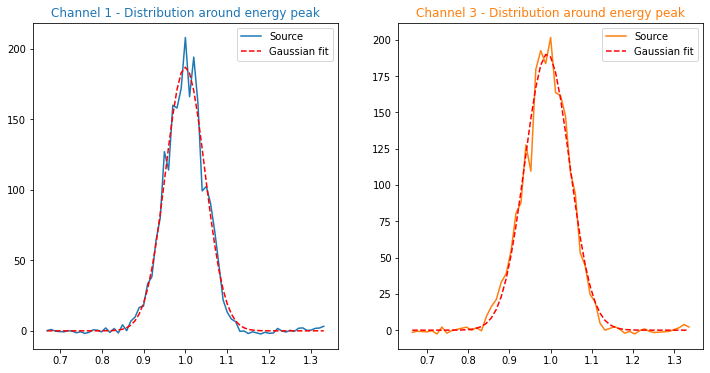

In [5]:
## Check lmfit
try:
  import lmfit
except:
  %pip install lmfit
  import lmfit

from lmfit.models import GaussianModel
from scipy import sparse

fig, a =  plt.subplots(1, 2, figsize = (12, 6))
a[0].set_title("Channel 1 - Distribution around energy peak", color = "C0")
a[1].set_title("Channel 3 - Distribution around energy peak", color = "C1")

# Define lower limit and upper limit of distribution MANUALLY around xxx keV
# Aprox. 3 sigmas around xxx keV
# llim0 = 344 # For 511 keV example
# ulim0 = 677 # For 511 keV example
# llim1 = 340 # For 511 keV example
# ulim1 = 682 # For 511 keV example
llim0 = 0.66
ulim0 = 1.34
llim1 = 0.66
ulim1 = 1.34
pkx0 = nx0[(llim0 < nx0) & (nx0 < ulim0)]
pky0 =  y0[(llim0 < nx0) & (nx0 < ulim0)]
pkx1 = nx1[(llim1 < nx1) & (nx1 < ulim1)]
pky1 =  y1[(llim1 < nx1) & (nx1 < ulim1)]

# "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens in 2005
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = sparse.linalg.spsolve(Z, w * y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Calculates baseline
lbsl0 = baseline_als(pky0, 10000, 0.01)
lbsl1 = baseline_als(pky1, 10000, 0.01)
#plt.plot(pkx0, lbsl0, 'k--') # Plot baseline
#plt.plot(pkx1, lbsl1, 'import matplotlib.pyplot as pltk--') # Plot baseline

# Remove baseline
spky0 = pky0 - lbsl0
spky1 = pky1 - lbsl1
a[0].plot(pkx0, spky0, color = 'C0', label = "Source") # Spectrum around 511 keV without baseline
a[1].plot(pkx1, spky1, color = 'C1', label = "Source") # Spectrum around 511 keV without baseline

# Report data analysis
mod = GaussianModel()
pars0 = mod.guess(spky0, x = pkx0)
out0  = mod.fit(spky0, pars0, x = pkx0)
print ("Detector 0:")
print (out0.fit_report(min_correl=0.25))
pars1 = mod.guess(spky1, x = pkx1)
out1  = mod.fit(spky1, pars1, x = pkx1)
print ("\nDetector 1:")
print (out1.fit_report(min_correl=0.25))

oy0 = out0.best_fit + lbsl0 
oy1 = out1.best_fit + lbsl1

#plt.plot(pkx0, oy0, 'r-')
#plt.plot(pkx1, oy1, 'r-')
a[0].plot(pkx0, out0.best_fit , 'r--', label = "Gaussian fit")
a[1].plot(pkx1, out1.best_fit , 'r--', label = "Gaussian fit")

a[0].legend()
a[1].legend()

Energy resolution***:
*** obs.: 
Channel 1: 11.1 +/- 0.2 %
Channel 3: 12.8 +/- 0.2 %


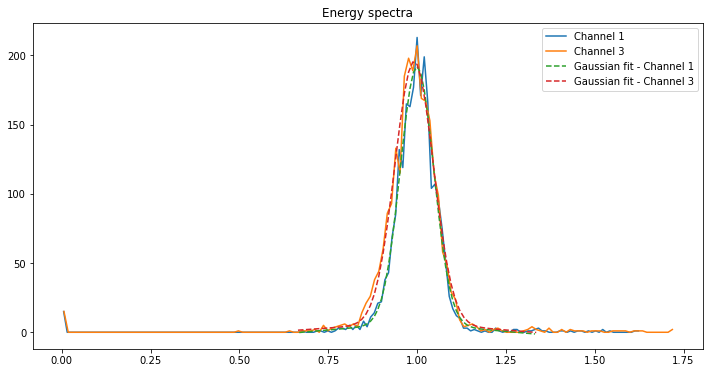

In [6]:
# Energy resolution for xxx keV

plt.figure(figsize=(12, 6))
plt.title('Energy spectra')
plt.plot(nx0, y0, label = "Channel 1")
plt.plot(nx1, y1, label = "Channel 3")
plt.plot(pkx0, oy0, '--', label = "Gaussian fit - Channel 1")
plt.plot(pkx1, oy1, '--', label = "Gaussian fit - Channel 3")
plt.legend()

print("Energy resolution***:")
print("*** obs.: ")
# 511 keV example:
# res0 = out0.params['fwhm'].value / 511 * 100
# sd_res0 = out0.params['fwhm'].stderr /511 * 100
# print("Detector 0: {:.1f} +/- {:.1f} %".format(res0, sd_res0,))
# res1 = out1.params['fwhm'].value / 511 * 100
# sd_res1 = out1.params['fwhm'].stderr /511 * 100
# print("Detector 1: {:.1f} +/- {:.1f} %".format(res1, sd_res1,))

res0 = out0.params['fwhm'].value / 1 * 100
sd_res0 = out0.params['fwhm'].stderr /1 * 100
print("Channel 1: {:.1f} +/- {:.1f} %".format(res0, sd_res0,))
res1 = out1.params['fwhm'].value / 1 * 100
sd_res1 = out1.params['fwhm'].stderr /1 * 100
print("Channel 3: {:.1f} +/- {:.1f} %".format(res1, sd_res1,))